In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.ma as ma
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [747]:
# Plots that will be used later on.

def plot_confusion_matrix(truth, predicted, labels={}, save_name='',
                          title='Confusion Matrix', norm=1, suppress_values=False,
                          diagonal_values=False,
                          font_size=16,
                          cmin=0,cmax=1,
                          cut_off = 1
                          ):
    # make confusion matrix from truth and predicted for classes
    # define the confusion matrix
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import numpy as np
    
    conf_mat = confusion_matrix(truth,predicted)
    
    #normalise
    if norm:
        conf_mat =  conf_mat.astype('float')/conf_mat.sum(axis=1)[:, np.newaxis]

    fig = plt.figure(figsize=(9,9))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    cb = fig.colorbar(res)
    
    res.set_clim(cmin, cmax)
    
    # add number overlay
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if (not suppress_values or (diagonal_values and i==j)) and c>0 :
                cent = .1
                if diagonal_values:
                    cent = .3
                
                if norm:
                    d = round(c,2)
                    plt.text(j-cent, i+.0, d, fontsize=font_size)
                else:
                    plt.text(j-cent, i+.0, c, fontsize=font_size)
    
            if (i==j) and c > cut_off:
                cent= 0.3
                plt.text(j-cent, i+.0, 'X', fontsize=font_size)

    # set axes
    if labels !={}:
        _ = plt.xticks(range(len(labels)), [labels[l] for l in labels], rotation=True, fontsize=font_size)
        _ = plt.yticks(range(len(labels)), [labels[l] for l in labels],fontsize=font_size)
        print(classification_report(truth, predicted,target_names=[l for l in labels.values()]))

    plt.xlabel('Predicted',fontsize=font_size+4)
    plt.ylabel('Truth',fontsize=font_size+4)
    plt.title(title,fontsize=font_size+5)

    if save_name != '':
        plt.savefig(save_name)

    plt.show()


def plot_delta_matrix(truth, predicted, predicted_2, labels={}, save_name='',
                      title='Delta Confusion Matrix', norm=1, suppress_values=False,
                      diagonal_values=True,
                      font_size=16,
                      cmin=-0.2,cmax=0.2,
                      cut_off = 1,
                      norm_recall = True
                      ):
    # make confusion matrix from truth and predicted for classes
    # define the confusion matrix
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import numpy as np
    
    # convert to int and generate labels if string
    if isinstance(truth[0],str) and isinstance(predicted[0], str) and isinstance(predicted_2[1], str):
        class_dict, labels = _generate_class_dicts(set(truth))
        truth = [class_dict[x] for x in truth]
        predicted = [class_dict[x] if x in class_dict else class_dict['S'] for x in predicted ]
        predicted_2 = [class_dict[x] if x in class_dict else class_dict['S'] for x in predicted_2 ]

    conf_mat = confusion_matrix(truth,predicted)
    conf_mat_2 = confusion_matrix(truth, predicted_2)

    #normalise
    title_type = ''
    if norm:
        if norm_recall:
            conf_mat =  conf_mat.astype('float')/conf_mat.sum(axis=1)[:, np.newaxis]
            conf_mat_2 =  conf_mat_2.astype('float')/conf_mat_2.sum(axis=1)[:, np.newaxis]
            title_type = 'Recall'
        else:
            #print('[delta_matrix]: plotting precision')
            conf_mat =  conf_mat.astype('float')/conf_mat.sum(axis=0)
            conf_mat_2 =  conf_mat_2.astype('float')/conf_mat_2.sum(axis=0)
            title_type = 'Precision'
    # take the delta map
    delta_conf_mat = (conf_mat_2 - conf_mat)
    
    #fig = plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(figsize=(10,10))
    
    width = np.shape(delta_conf_mat)[1]
    height = np.shape(delta_conf_mat)[0]
    
    res = plt.imshow(np.array(delta_conf_mat), cmap=plt.cm.RdYlGn, interpolation='nearest')
    cb = fig.colorbar(res)
    
    res.set_clim(cmin, cmax)
    
    # add number overlay
    for i, row in enumerate(delta_conf_mat):
        for j, c in enumerate(row):
            if (not suppress_values or (diagonal_values and i==j)):
                cent = .1
                if diagonal_values:
                    cent = .3
                
                if norm:
                    d = round(c,2)
                    plt.text(j-cent, i+.0, d, fontsize=font_size-5)
                else:
                    plt.text(j-cent, i+.0, c, fontsize=font_size-5)
    
            if (i==j) and c > cut_off:
                cent= 0.3
                plt.text(j-cent, i+.0, 'X', fontsize=font_size-5)

    # set axes
    if labels !={}:
        _ = plt.xticks(range(len(labels)), [labels[l] for l in labels], rotation=90, fontsize=font_size)
        _ = plt.yticks(range(len(labels)), [labels[l] for l in labels],fontsize=font_size)
        print(classification_report(truth, predicted,target_names=[l for l in labels.values()]))
        print(classification_report(truth, predicted_2,target_names=[l for l in labels.values()]))

    plt.xlabel('Predicted',fontsize=font_size+4)
    plt.ylabel('Truth',fontsize=font_size+4)
    plt.title(title_type+' '+title,fontsize=font_size+5)

    cb.ax.get_yaxis().labelpad = 20
    cb.ax.set_ylabel('Delta Percentage Points', rotation=270, size=18)
    plt.show()
    
    if save_name != '':
        plt.savefig(save_name)
        
def plot_delta_rpc(truth, predicted, predicted_2, labels={},save_name='', x_min=-0.15, x_max=0.15, y_min=-0.15, y_max=0.15):
    """
    plot recall vs precision vs count
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    
    # convert to int and generate labels if string
    if isinstance(truth[0],str) and isinstance(predicted[0], str) and isinstance(predicted_2[1], str):
        class_dict, labels = _generate_class_dicts(set(truth))
        truth = [class_dict[x] for x in truth]
        predicted = [class_dict[x] for x in predicted if x in class_dict]
        predicted_2 = [class_dict[x] for x in predicted_2 if x in class_dict]

    import numpy as np
    fig, ax = plt.subplots(figsize=(10,8))

    # get counts of the truth set
    y_counts_train = []
    for i in range(len(set(truth))):
        y_counts_train.append(len([x for x in truth if x==i]))

    labels = [labels[l] for l in labels]
    
    #plt.figure(figsize=(20,10))
    plt.title('Precision vs Recall',fontsize=15)
    plt.xlabel('Recall',fontsize=18)
    plt.ylabel('Precision',fontsize=18)
    
    
    #colors.LogNorm(vmin=Z1.min(), vmax=Z1.max())
    # plot the points
    delta_recall = recall_score(truth, predicted_2,average=None) - recall_score(truth, predicted,average=None)
    delta_precision = precision_score(truth, predicted_2,average=None) - precision_score(truth, predicted,average=None)
    
    #print( recall_score(truth, predicted_2,average=None))
    #print( recall_score(truth, predicted,average=None))
    #print(delta_recall)
    from matplotlib.colors import LogNorm
    cax = plt.scatter(
                      delta_recall
                      , delta_precision
                      , marker = 'o'
                      , s=400
                      , c = recall_score(truth, predicted,average=None)  #_train #y_counts
                      , cmap = plt.get_cmap('Spectral')
                      , norm= LogNorm(np.min(recall_score(truth, predicted,average=None) ), vmax=np.max(recall_score(truth, predicted,average=None) ))#, cmap='PuBu_r'
                      #,
                      )
    plt.ylim(y_min,y_max)
    plt.xlim(x_min,x_max)
    cbar = plt.colorbar()
                      
    #cbar.ax.set_ylabel('Original Recall', rotation=270)
                      
    # add labels to each point
    for label, x, y in zip(labels,delta_recall, delta_precision):
        plt.annotate(
                    label,
                    xy = (x, y),
                    xytext = (10, 20),
                    textcoords = 'offset points',
                    ha = 'right', va = 'bottom',
                    bbox = dict(boxstyle = 'round,pad=0.2', fc = 'yellow', alpha = 0.2),
                     arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
                      
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.set_ylabel('Final Recall', rotation=270, size=18)
    plt.plot((0, 0.), (0., 1), 'k-',alpha=0.5,color='g',linewidth=5)
    plt.plot((0, 1.), (0., 0), 'k-',alpha=0.5,color='g',linewidth=5)
    plt.plot((0, 0.), (0., -1), 'k-',alpha=0.5,color='r',linewidth=5)
    plt.plot((0, -1.), (0., 0), 'k-',alpha=0.5,color='r',linewidth=5)
    #plt.plot((0.6, 0.6), (0, 0.6), 'k-',alpha=0.5,color='red',linewidth=5)
    
    if save_name != '':
        plt.savefig(save_name)

    plt.show()

In [3]:
train_ratings = pd.read_csv('training_ratings_for_kaggle_comp.csv')
with open('users.dat','r') as f:
    users = pd.DataFrame(l.rstrip().split('::') for l in f)
    users.columns = ['user', 'gender', 'age', 'occupation', 'zip-code']
    users.user = pd.to_numeric(users.user)  #Allows merging
with open('movies.dat','r') as f:
    movies = pd.DataFrame(l.rstrip().split('::') for l in f)
    movies.columns = ['movie', 'title', 'genre']
    movies.movie = pd.to_numeric(movies.movie)

In [749]:
train_ratings.head()

,user,movie,rating,id
0,2783,1253,5,2783_1253
1,2783,589,5,2783_589
2,2783,1270,4,2783_1270
3,2783,1274,4,2783_1274
4,2783,741,5,2783_741


In [750]:
print('Unique Users: {}'.format(train_ratings.user.nunique()))
print('Uniqie Movies: {}'.format(train_ratings.movie.nunique()))

Unique Users: 3255
Uniqie Movies: 3551


In [6]:
def remove_zero_columns(sparse_matrix):
    sparse = sparse_matrix.T.toarray()[~np.all(sparse_matrix.T.toarray()==0, axis=1)]
    return csr_matrix(sparse.T)

def user_item_sparse(rating_df):
    
    ratings_df_list = rating_df.values.tolist()
    
    indptr = [0]
    indices = []
    data = []

    cur_usr = ratings_df_list[0][0]
    count = 1

    for row in ratings_df_list:
        if row[0] != cur_usr:
            indptr.append(len(indices))
            cur_usr = row[0]
            count += 1
        indices.append(row[1]-1)
        data.append(row[2])
    indptr.append(len(indices))

    return remove_zero_columns(csr_matrix((data, indices, indptr)))

In [7]:
sparse = user_item_sparse(train_ratings)
sparse

<3255x3551 sparse matrix of type '<class 'numpy.int32'>'
	with 500100 stored elements in Compressed Sparse Row format>

In [8]:
# 500100 nonzero cells
print('Percent of Non-Empty Cells: {}%'.format(sparse.nnz / (sparse.shape[0]*sparse.shape[1]) * 100))

Percent of Non-Empty Cells: 4.326684117020324%


In [9]:
ratings = sparse.toarray()

In [47]:
def train_test_split(sparse_matrix, percent=0.2):
    y_train = sparse_matrix.toarray()
    
    i, j = np.nonzero(y_train)
    size = int(percent * len(i))
    ix = np.random.choice(len(i), size, replace=False)
    y_test = [(x_ind, y_ind, rating) for x_ind, y_ind, rating in zip(i[ix], j[ix], y_train[i[ix], j[ix]])]

    print(y_train.nonzero()[0].shape[0])
    
    y_train[i[ix], j[ix]] = 0
    
    print(y_train.nonzero()[0].shape[0])
    
    return csr_matrix(y_train), y_test, i, j, ix

In [10]:
def key_index_finder(ratings):
    key_user_indices = []
    
    for x in range(ratings.shape[0]):
        if len(ratings[x].nonzero()[0])<=2:
            key_user_indices.append(x)

    key_item_indices = []
    for x in range(ratings.T.shape[0]):
        if len(ratings.T[x].nonzero()[0])<=2:
            key_item_indices.append(x)
    
    return key_user_indices, key_item_indices

def train_test_split(original_matrix, percent=0.2):
    
    y_train = sparse.toarray()
    
    key_user_indices, key_item_indices = key_index_finder(y_train)
    
    i, j = np.nonzero(y_train)
    size = int(0.2 * len(i))
    ix = np.random.choice(len(i), size, replace=False)
    
    mask = np.zeros(j[ix].shape[0])

    index = 0
    for entry in j[ix]:
        if entry in key_item_indices:
            mask[index]=1
        index+=1 
    
    ix_real = ma.masked_array(ix, mask)
    
    y_test = [(x_ind, y_ind, rating) for x_ind, y_ind, rating in zip(i[ix_real.compressed()], j[ix_real.compressed()],
                                                                 y_train[i[ix_real.compressed()], j[ix_real.compressed()]])]
    
    y_train[i[ix_real.compressed()], j[ix_real.compressed()]] = 0

In [19]:
key_user_indices = []
for x in range(ratings.shape[0]):
    if len(ratings[x].nonzero()[0])<=2:
        key_user_indices.append(x)

key_item_indices = []
for x in range(ratings.T.shape[0]):
    if len(ratings.T[x].nonzero()[0])<=2:
        key_item_indices.append(x)

In [20]:
len(key_user_indices), len(key_item_indices)

(2, 242)

In [33]:
y_train = sparse.toarray()
    
i, j = np.nonzero(y_train)
size = int(0.2 * len(i))
ix = np.random.choice(len(i), size, replace=False)

In [34]:
mask = np.zeros(j[ix].shape[0])

index = 0
for m in j[ix]:
    if m in key_item_indices:
        mask[index]=1
    index+=1    

ix_real = np.ma.masked_array(ix, mask)

In [35]:
y_test = [(x_ind, y_ind, rating) for x_ind, y_ind, rating in zip(i[ix_real.compressed()], j[ix_real.compressed()],
                                                                 y_train[i[ix_real.compressed()], j[ix_real.compressed()]])]

In [36]:
y_train[i[ix_real.compressed()], j[ix_real.compressed()]] = 0

In [37]:
item_sim = cosine_similarity(y_train.T)
user_sim = cosine_similarity(y_train)

In [38]:
# Check that min is not 0
np.diagonal(item_sim).min(), np.diagonal(user_sim).min()

(0.99999999999999922, 0.999999999999999)

In [39]:
sparse.nnz-len(ix_real)

400080

In [40]:
# How many items were not set to 0 in order to allow cf to work by item
len(ix_real)-len(ix_real.compressed())

61

In [71]:
len(y_train.T.nonzero()[0])

400147

In [41]:
count=0
for row in y_train.T:
    if len(row.nonzero()[0])==0:
        print(count)
        
    count+=1

In [42]:
count=0
for row in y_train:
    if len(row.nonzero()[0])==0:
        print(count)
        
    count+=1

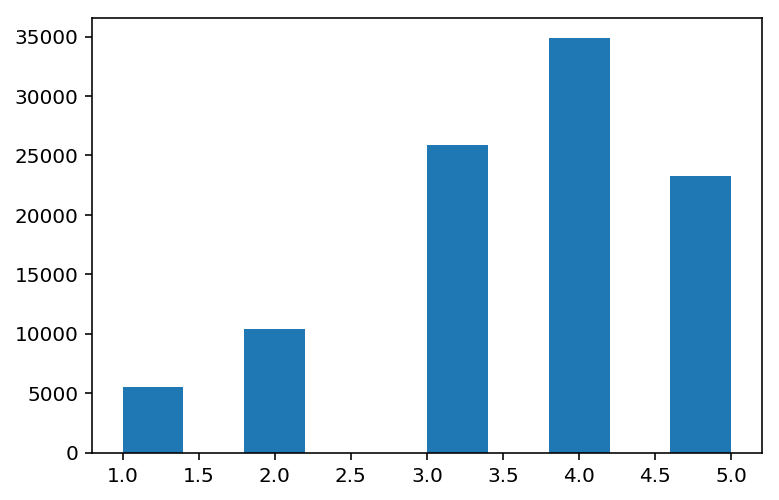

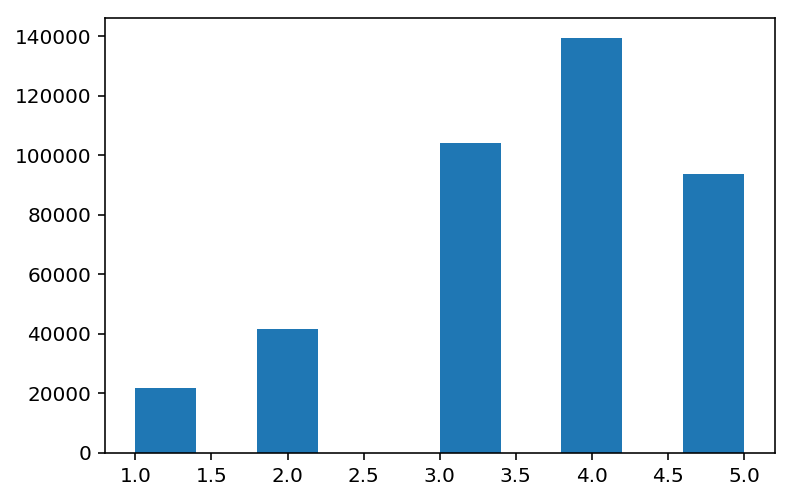

In [751]:
test_rats = []
for tpl in y_test:
    test_rats.append(tpl[2])
train_rats = np.array(y_train[y_train.nonzero()])
plt.hist(test_rats)
plt.show()
plt.hist(train_rats)
plt.show()

In [44]:
train_counts = Counter(train_rats)
test_counts = Counter(test_rats)

In [667]:
for x in range(1, 6):
    print(test_counts[x]/train_counts[x])

0.25396679812895534
0.2503071327054176
0.24907241863237017
0.250371775253777
0.24860296396020984


In [668]:
# Relative percent of ratings to rating 4 which has the most ratings
for x in range(1, 6):
    print(test_counts[x]/test_counts[4], train_counts[x]/train_counts[4])

0.1589050529396574 0.15665567505046804
0.29815500272589024 0.2982320021264826
0.7435080772431207 0.7473867971292485
1.0 1.0
0.6676135548477805 0.6723636285264769


In [347]:
# NEED TO FIX THIS SO THAT IT LEAVES AT LEAST 1 NONZERO ELEMENT PER ROW/COLUMN
def train_test_split(sparse_matrix, percent=0.2):
    y_train = sparse_matrix.toarray()
    
    i, j = np.nonzero(y_train)
    size = int(percent * len(i))
    ix = np.random.choice(len(i), size, replace=False)
    y_test = [(x_ind, y_ind, rating) for x_ind, y_ind, rating in zip(i[ix], j[ix], y_train[i[ix], j[ix]])]
    y_test[:5]
    print(y_train.nonzero()[0].shape[0])
    y_train[i[ix], j[ix]] = 0
    print(y_train.nonzero()[0].shape[0])
    return csr_matrix(y_train), y_test, i, j, ix

y_train, y_test, i, j, ix= train_test_split(sparse, percent=0.2)

In [47]:
item_means = []
user_means = []
for x in item_sim:
    item_means.append(x.mean())
for x in user_sim:
    user_means.append(x.mean())

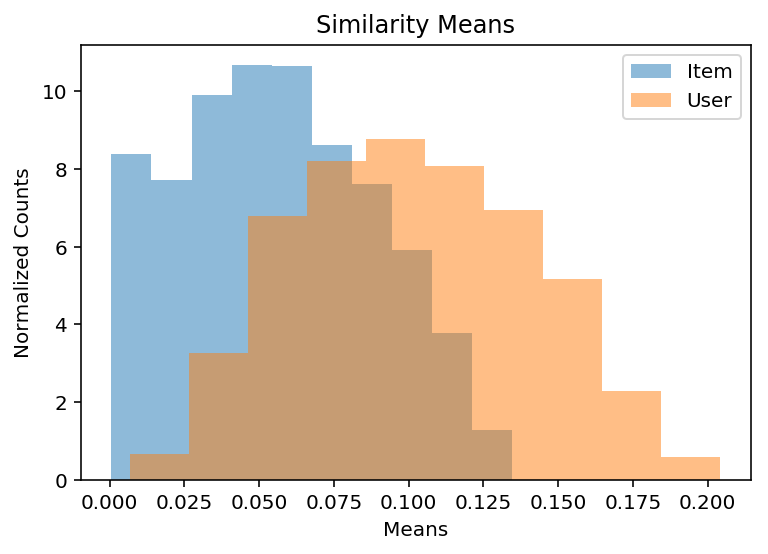

In [755]:
# Can see how the mean movie similarity is on average less than the mean user similarity
plt.title("Similarity Means")
plt.hist(item_means, normed=True, alpha=0.5, label='Item')
plt.hist(user_means, normed=True, alpha=0.5, label='User')
plt.xlabel("Means")
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

In [49]:
# Maybe make a graph showing how slow this part is as neighbors increases

# Just try average rating of items by the neighbors
def testing(y_train, sim, n, kind='user'):
    neighbors=[]

    if kind=='item':
        y_train=y_train.T
        
#     if kind=='user':
#         preds = np.zeros(shape=y_train.shape) # Makes an empty array to fill with values
#         row_means = np.array([y_train.sum(axis=1)/(y_train!=0).sum(axis=1)]).T # Means based on values that were not dropped
    
#     elif kind=='item':
#         preds = np.zeros(shape=y_train.T.shape) # Makes an empty array to fill with values
#         row_means = np.array([y_train.T.sum(axis=1)/(y_train.T!=0).sum(axis=1)]).T # Means based on values that were not dropped
    
    preds = np.zeros(shape=y_train.shape) # Makes an empty array to fill with values
    row_means = np.array([y_train.sum(axis=1)/(y_train!=0).sum(axis=1)]).T # Means based on values that were not dropped
#     return preds, row_means

    print('Finding Neighbors')
    for x in range(sim.shape[0]):
        neighbors.append(sim[x].argsort()[-(n+1):-1][::-1])

    print('Calculating Movie Predictions')
    for user in range(y_train.shape[0]):
        
        if user%1000==0:
            print(user/y_train.shape[0])
            
        for movie in range(y_train.shape[1]):
    
            num = 0
            sig_weights = 0
        
            for neigh in neighbors[user]:
            
                if y_train[neigh][movie]==0:                
                    continue
                else:
                    num += ((y_train[neigh][movie]-row_means[neigh])[0]*sim[user][neigh])
                    sig_weights += sim[neigh][user]
        
            if sig_weights==0:
                sig_weights=1
        
            preds[user][movie] = row_means[user] + num/sig_weights
    
    return preds

# def RMSE(raw_preds, dense_matrix, sparse_matrix, i, j, ix):
     
#     train_preds = np.rint(np.clip(raw_preds[sparse_matrix.toarray().nonzero()], a_min=1, a_max=5))
#     train_actual = dense_matrix[sparse_matrix.toarray().nonzero()]
    
#     test_preds = np.rint(np.clip(raw_preds[i[ix], j[ix]], a_min=1, a_max=5))
#     test_actual = dense_matrix[i[ix], j[ix]]
    
#     train_rmse = np.sqrt(((train_actual-train_preds) **2).mean())
#     test_rmse = np.sqrt(((test_actual-test_preds) **2).mean())
    
#     return train_rmse, test_rmse, train_preds, train_actual, test_preds, test_actual

In [433]:
item10 = testing(y_train, item_sim, n=10, kind='item')
user10 = testing(y_train, user_sim, n=10, kind='user')

item20 = testing(y_train, item_sim, n=20, kind='item')
user20 = testing(y_train, user_sim, n=20, kind='user')

item30 = testing(y_train, item_sim, n=30, kind='item')
user30 = testing(y_train, user_sim, n=30, kind='user')

item40 = testing(y_train, item_sim, n=40, kind='item')
user40 = testing(y_train, user_sim, n=40, kind='user')

item50 = testing(y_train, item_sim, n=50, kind='item')
user50 = testing(y_train, user_sim, n=50, kind='user')

Finding Neighbors
Calculating Movie Predictions
0.0
0.28161081385525205
0.5632216277105041
0.8448324415657561
Finding Neighbors
Calculating Movie Predictions
0.0
0.30721966205837176
0.6144393241167435
0.9216589861751152


In [437]:
item60 = testing(y_train, item_sim, n=60, kind='item')
user60 = testing(y_train, user_sim, n=60, kind='user')

item70 = testing(y_train, item_sim, n=70, kind='item')
user70 = testing(y_train, user_sim, n=70, kind='user')

item80 = testing(y_train, item_sim, n=80, kind='item')
user80 = testing(y_train, user_sim, n=80, kind='user')

item90 = testing(y_train, item_sim, n=90, kind='item')
user90 = testing(y_train, user_sim, n=90, kind='user')

item100 = testing(y_train, item_sim, n=100, kind='item')
user100 = testing(y_train, user_sim, n=100, kind='user')

Finding Neighbors
Calculating Movie Predictions
0.0
0.28161081385525205
0.5632216277105041
0.8448324415657561
Finding Neighbors
Calculating Movie Predictions
0.0
0.30721966205837176
0.6144393241167435
0.9216589861751152
Finding Neighbors
Calculating Movie Predictions
0.0
0.28161081385525205
0.5632216277105041
0.8448324415657561
Finding Neighbors
Calculating Movie Predictions
0.0
0.30721966205837176
0.6144393241167435
0.9216589861751152
Finding Neighbors
Calculating Movie Predictions
0.0
0.28161081385525205
0.5632216277105041
0.8448324415657561
Finding Neighbors
Calculating Movie Predictions
0.0
0.30721966205837176
0.6144393241167435
0.9216589861751152
Finding Neighbors
Calculating Movie Predictions
0.0
0.28161081385525205
0.5632216277105041
0.8448324415657561
Finding Neighbors
Calculating Movie Predictions
0.0
0.30721966205837176
0.6144393241167435
0.9216589861751152
Finding Neighbors
Calculating Movie Predictions
0.0
0.28161081385525205
0.5632216277105041
0.8448324415657561
Finding Ne

In [438]:
item10_train, item10_test, item10_train_preds, item10_train_actual, item10_test_preds, item10_test_actual = RMSE(item10.T, ratings, csr_matrix(y_train), i, j, ix)
user10_train, user10_test, user10_train_preds, user10_train_actual, user10_test_preds, user10_test_actual = RMSE(user10, ratings, csr_matrix(y_train), i, j, ix)

item20_train, item20_test, item20_train_preds, item20_train_actual, item20_test_preds, item20_test_actual = RMSE(item20.T, ratings, csr_matrix(y_train), i, j, ix)
user20_train, user20_test, user20_train_preds, user20_train_actual, user20_test_preds, user20_test_actual = RMSE(user20, ratings, csr_matrix(y_train), i, j, ix)

item30_train, item30_test, item30_train_preds, item30_train_actual, item30_test_preds, item30_test_actual = RMSE(item30.T, ratings, csr_matrix(y_train), i, j, ix)
user30_train, user30_test, user30_train_preds, user30_train_actual, user30_test_preds, user30_test_actual = RMSE(user30, ratings, csr_matrix(y_train), i, j, ix)

item40_train, item40_test, item40_train_preds, item40_train_actual, item40_test_preds, item40_test_actual = RMSE(item40.T, ratings, csr_matrix(y_train), i, j, ix)
user40_train, user40_test, user40_train_preds, user40_train_actual, user40_test_preds, user40_test_actual = RMSE(user40, ratings, csr_matrix(y_train), i, j, ix)

item50_train, item50_test, item50_train_preds, item50_train_actual, item50_test_preds, item50_test_actual = RMSE(item50.T, ratings, csr_matrix(y_train), i, j, ix)
user50_train, user50_test, user50_train_preds, user50_train_actual, user50_test_preds, user50_test_actual = RMSE(user50, ratings, csr_matrix(y_train), i, j, ix)

In [443]:
item60_train, item60_test, item60_train_preds, item60_train_actual, item60_test_preds, item60_test_actual = RMSE(item60.T, ratings, csr_matrix(y_train), i, j, ix)
user60_train, user60_test, user60_train_preds, user60_train_actual, user60_test_preds, user60_test_actual = RMSE(user60, ratings, csr_matrix(y_train), i, j, ix)

item70_train, item70_test, item70_train_preds, item70_train_actual, item70_test_preds, item70_test_actual = RMSE(item70.T, ratings, csr_matrix(y_train), i, j, ix)
user70_train, user70_test, user70_train_preds, user70_train_actual, user70_test_preds, user70_test_actual = RMSE(user70, ratings, csr_matrix(y_train), i, j, ix)

item80_train, item80_test, item80_train_preds, item80_train_actual, item80_test_preds, item80_test_actual = RMSE(item80.T, ratings, csr_matrix(y_train), i, j, ix)
user80_train, user80_test, user80_train_preds, user80_train_actual, user80_test_preds, user80_test_actual = RMSE(user80, ratings, csr_matrix(y_train), i, j, ix)

item90_train, item90_test, item90_train_preds, item90_train_actual, item90_test_preds, item90_test_actual = RMSE(item90.T, ratings, csr_matrix(y_train), i, j, ix)
user90_train, user90_test, user90_train_preds, user90_train_actual, user90_test_preds, user90_test_actual = RMSE(user90, ratings, csr_matrix(y_train), i, j, ix)

item100_train, item100_test, item100_train_preds, item100_train_actual, item100_test_preds, item100_test_actual = RMSE(item100.T, ratings, csr_matrix(y_train), i, j, ix)
user100_train, user100_test, user100_train_preds, user100_train_actual, user100_test_preds, user100_test_actual = RMSE(user100, ratings, csr_matrix(y_train), i, j, ix)

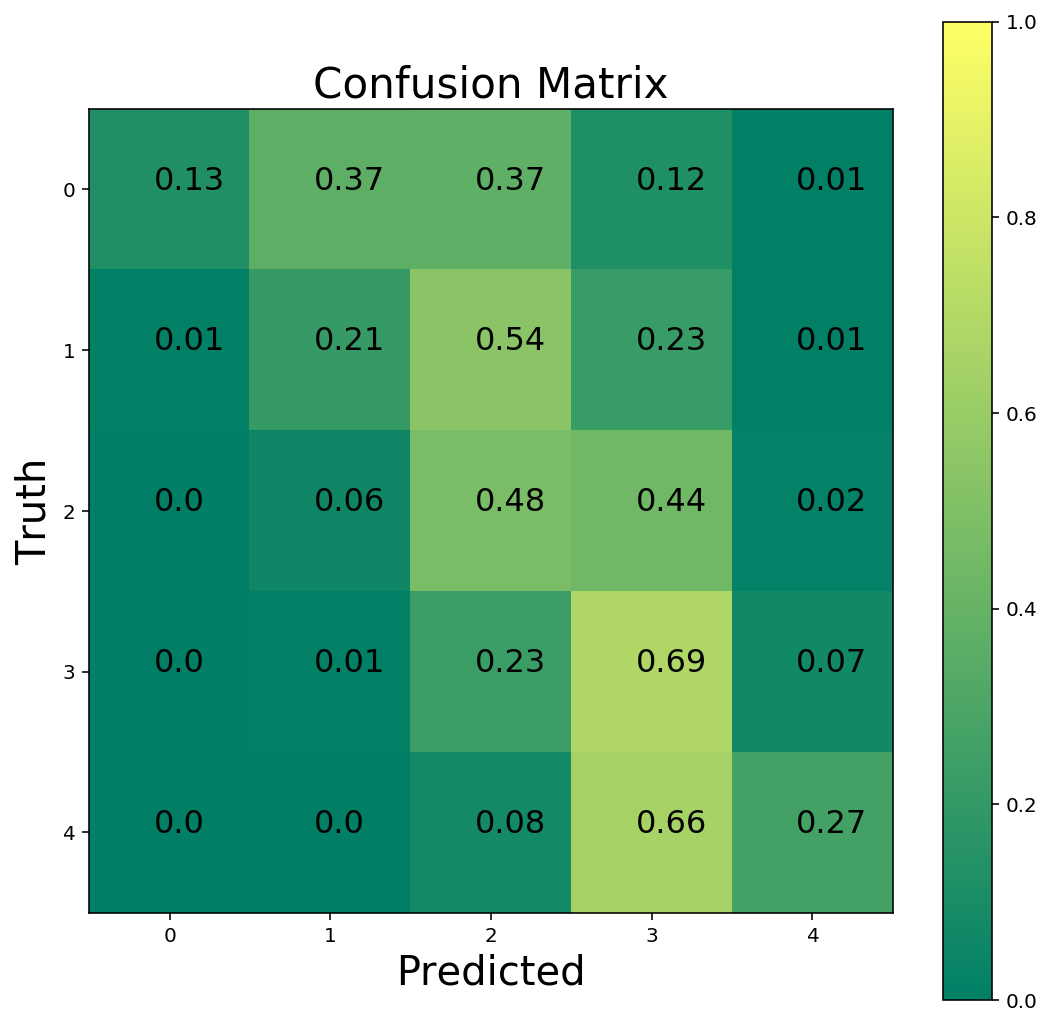

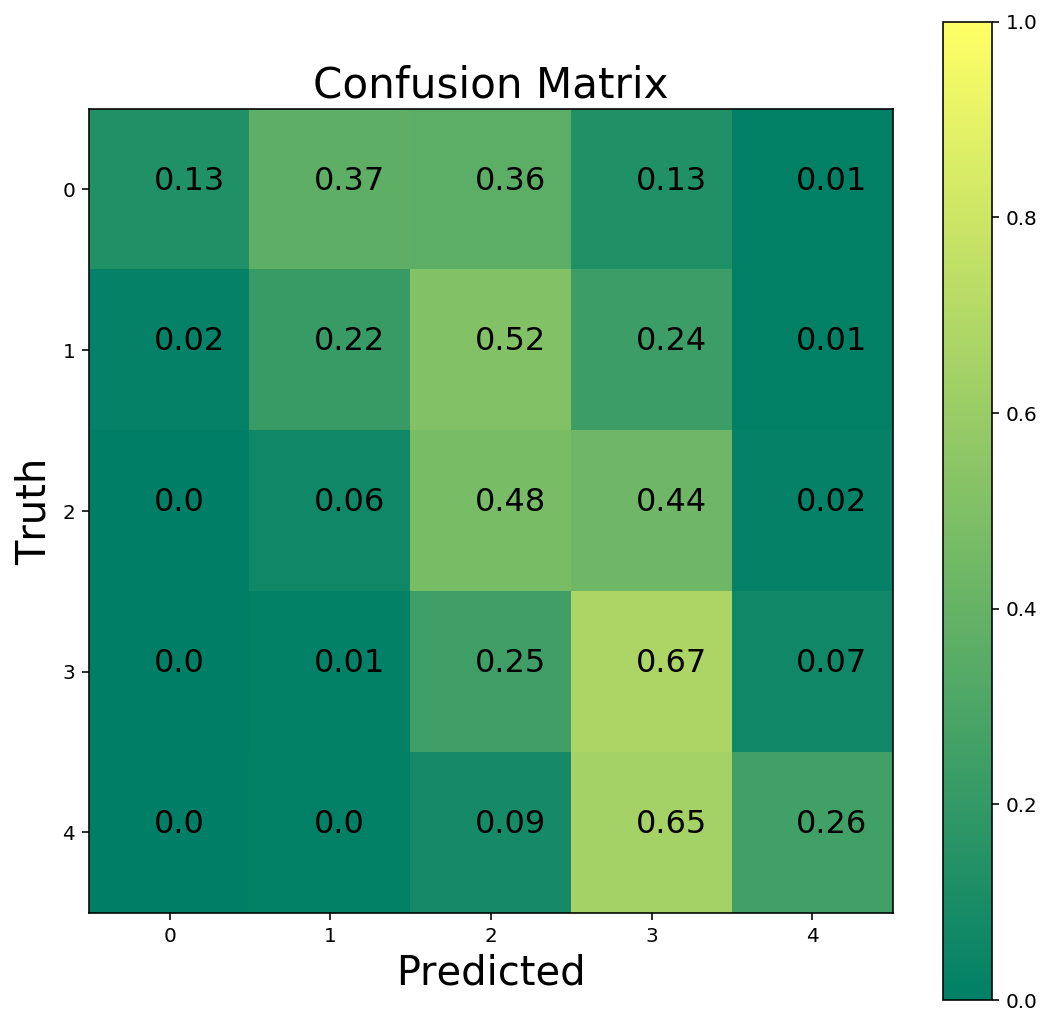

In [671]:
plot_confusion_matrix(item100_train_actual, item100_train_preds)
plt.show()
plot_confusion_matrix(item100_test_actual, item100_test_preds)
plt.show()

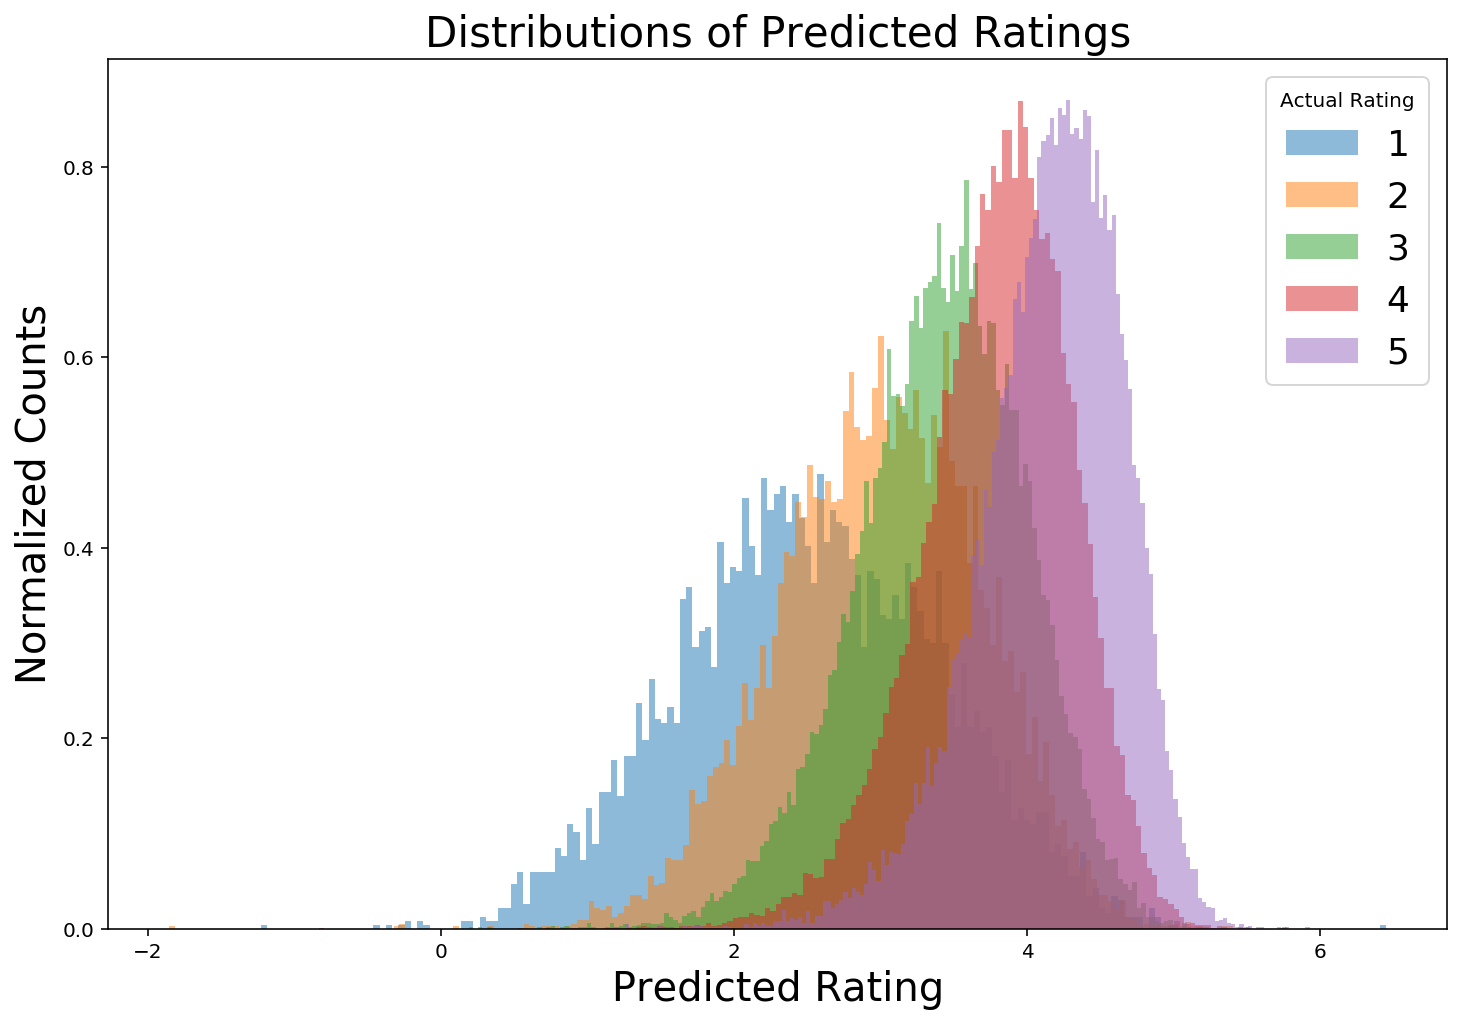

In [761]:
def plot_class_hist(actual, pred_mat, ratings, bins, i=i, j=j, ix=ix, font_size=20):
    
    plt.figure(figsize=(12,8))
    plt.title("Distributions of Predicted Ratings", fontsize=font_size+1)
    plt.ylabel("Normalized Counts", fontsize=font_size)
    plt.xlabel("Predicted Rating", fontsize=font_size)
    
    raw_preds = pred_mat[i[ix], j[ix]]
    for rating in ratings:
        pred_set = []
        index = 0
        for x in actual:
            if x==rating:
                pred_set.append(raw_preds[index])
            index+=1
        plt.hist(pred_set, alpha=0.5, bins=bins, normed=True, label=str(rating))
        plt.legend(title='Actual Rating', fontsize=font_size-2)
    plt.show()
    
plot_class_hist(actual=item100_test_actual, pred_mat=item100.T, ratings=[1,2,3,4,5], bins=180)

In [548]:
def RMSE_Adjusted(pred_mat, sparse_mat, i, j, ix):
    raw_adjust = pred_mat.T[sparse_mat.nonzero()]
    for index, item in enumerate(raw_adjust):
        if item<=2.4:
            raw_adjust[index] = 1
        elif item<=3.1:
            raw_adjust[index] = 2
        elif item<=3.6:
            raw_adjust[index] = 3
        elif item<=4.1:
            raw_adjust[index] = 4
        else:
            raw_adjust[index] = 5
    a = np.rint(raw_adjust)

    raw_adjust_test = pred_mat.T[i[ix], j[ix]]
    for index, item in enumerate(raw_adjust_test):
        if item<=2.4:
            raw_adjust_test[index] = 1
        elif item<=3.1:
            raw_adjust_test[index] = 2
        elif item<=3.6:
            raw_adjust_test[index] = 3
        elif item<=4.1:
            raw_adjust_test[index] = 4
        else:
            raw_adjust_test[index] = 5
    b = np.rint(raw_adjust_test)
    
    train_rmse = np.sqrt(((item100_train_actual-a) **2).mean())
    test_rmse = np.sqrt(((item100_test_actual-b) **2).mean())
    
    return train_rmse, test_rmse, a, b

In [513]:
item10_train, item10_test, i10a, i10b = RMSE_Adjusted(item10, y_train, i, j, ix)
item20_train, item20_test, i20a, i20b = RMSE_Adjusted(item20, y_train, i, j, ix)
item30_train, item30_test, i30a, i30b = RMSE_Adjusted(item30, y_train, i, j, ix)
item40_train, item40_test, i40a, i40b = RMSE_Adjusted(item40, y_train, i, j, ix)
item50_train, item50_test, i50a, i50b = RMSE_Adjusted(item50, y_train, i, j, ix)
item60_train, item60_test, i60a, i60b = RMSE_Adjusted(item60, y_train, i, j, ix)
item70_train, item70_test, i70a, i70b = RMSE_Adjusted(item70, y_train, i, j, ix)
item80_train, item80_test, i80a, i80b = RMSE_Adjusted(item80, y_train, i, j, ix)
item90_train, item90_test, i90a, i90b = RMSE_Adjusted(item90, y_train, i, j, ix)
item100_train, item100_test, i100a, i100b = RMSE_Adjusted(item100, y_train, i, j, ix)

In [527]:
user10_train, user10_test, u10a, u10b = RMSE_Adjusted(user10.T, y_train, i, j, ix)
user20_train, user20_test, u20a, u20b = RMSE_Adjusted(user20.T, y_train, i, j, ix)
user30_train, user30_test, u30a, u30b = RMSE_Adjusted(user30.T, y_train, i, j, ix)
user40_train, user40_test, u40a, u40b = RMSE_Adjusted(user40.T, y_train, i, j, ix)
user50_train, user50_test, u50a, u50b = RMSE_Adjusted(user50.T, y_train, i, j, ix)
user60_train, user60_test, u60a, u60b = RMSE_Adjusted(user60.T, y_train, i, j, ix)
user70_train, user70_test, u70a, u70b = RMSE_Adjusted(user70.T, y_train, i, j, ix)
user80_train, user80_test, u80a, u80b = RMSE_Adjusted(user80.T, y_train, i, j, ix)
user90_train, user90_test, u90a, u90b = RMSE_Adjusted(user90.T, y_train, i, j, ix)
user100_train, user100_test, u100a, u100b = RMSE_Adjusted(user100.T, y_train, i, j, ix)

In [730]:
item_train_scores = [item10_train, item20_train, item30_train, item40_train, item50_train,
                    item60_train, item70_train, item80_train, item90_train, item100_train]

user_train_scores = [user10_train, user20_train, user30_train, user40_train, user50_train,
                    user60_train, user70_train, user80_train, user90_train, user100_train]

item_test_scores = [item10_test, item20_test, item30_test, item40_test, item50_test,
                    item60_test, item70_test, item80_test, item90_test, item100_test]

user_test_scores = [user10_test, user20_test, user30_test, user40_test, user50_test,
                    user60_test, user70_test, user80_test, user90_test, user100_test]

neighbors = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

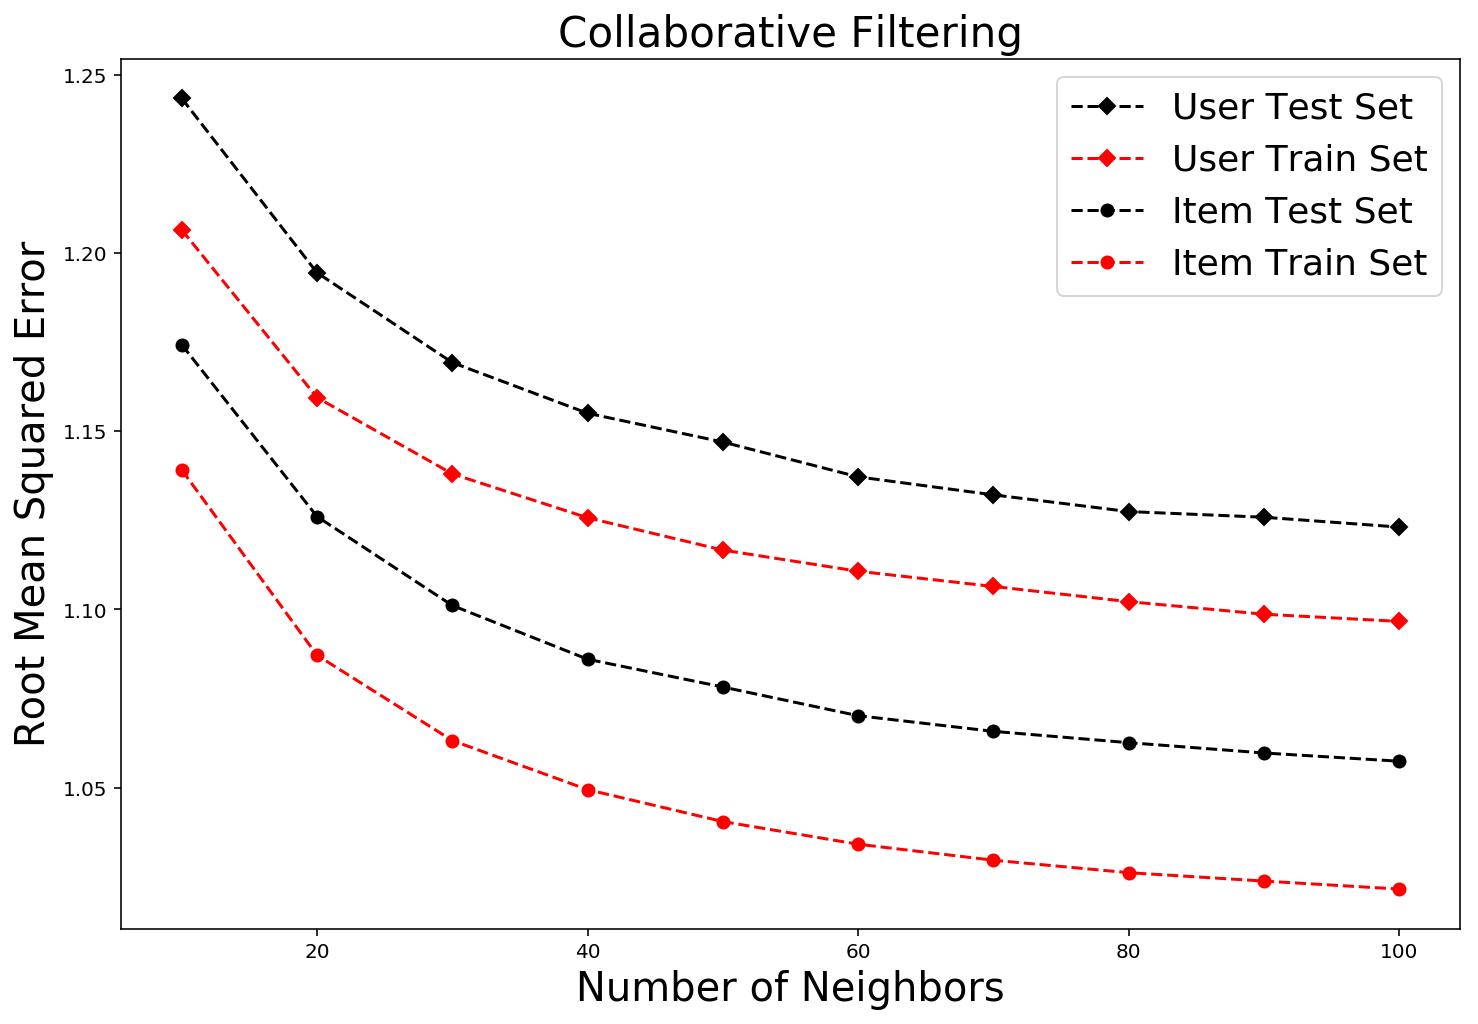

In [737]:
plt.figure(figsize=(12, 8))
plt.plot(neighbors, user_test_scores, linestyle='--', marker='D', color='k', label='User Test Set')
plt.plot(neighbors, user_train_scores, linestyle='--', marker='D', color='r', label='User Train Set')
plt.plot(neighbors, item_test_scores, linestyle='--', marker='o', color='k', label='Item Test Set')
plt.plot(neighbors, item_train_scores, linestyle='--', marker='o', color='r', label='Item Train Set')
plt.legend(fontsize=18)
plt.title('Collaborative Filtering', fontsize=21)
plt.xlabel('Number of Neighbors', fontsize=20)
plt.ylabel('Root Mean Squared Error', fontsize=20)
plt.show()

             precision    recall  f1-score   support

          1       0.40      0.45      0.43      5547
          2       0.25      0.35      0.29     10397
          3       0.38      0.33      0.36     25929
          4       0.46      0.39      0.42     34869
          5       0.51      0.59      0.55     23278

avg / total       0.43      0.42      0.42    100020



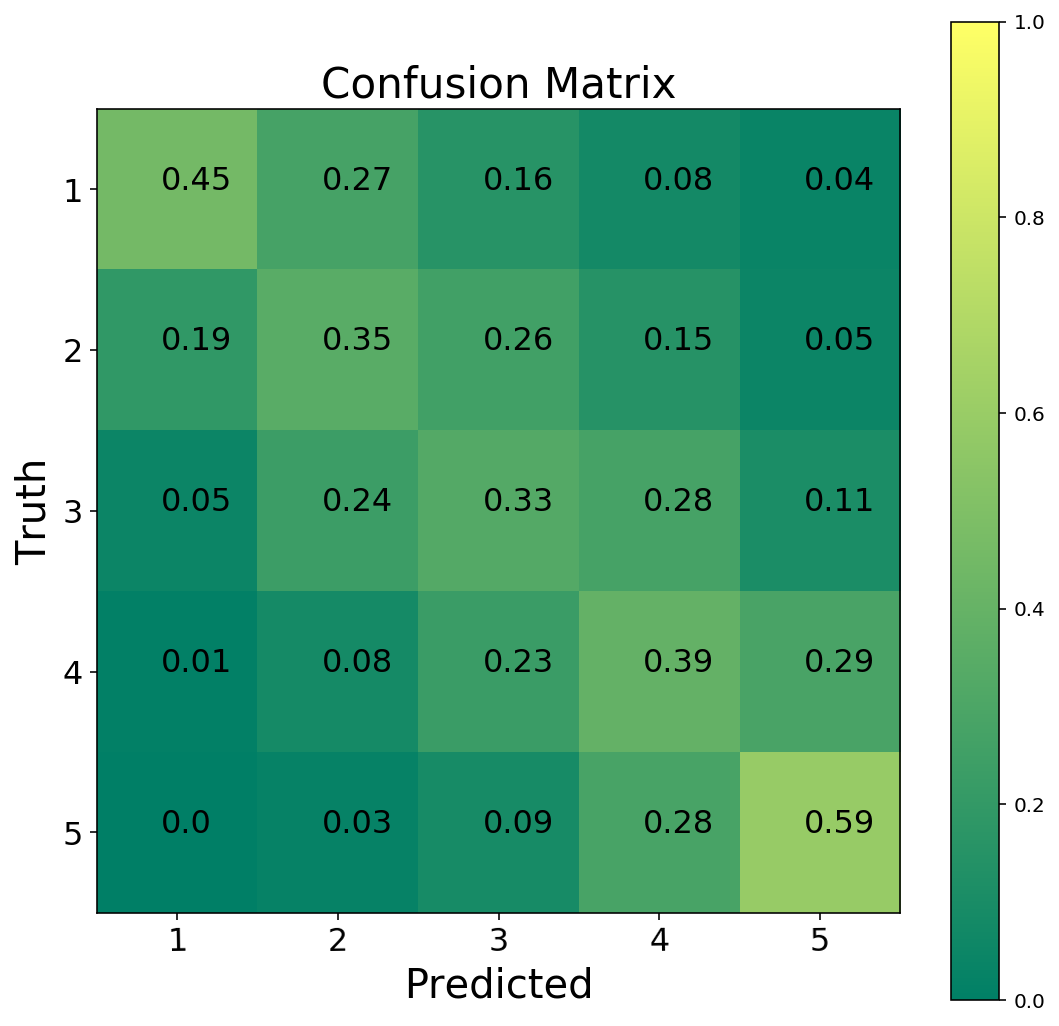

In [726]:
plot_confusion_matrix(item100_test_actual, i100b, labels={0:'1',1:'2',2:'3',3:'4',4:'5'})

             precision    recall  f1-score   support

          1       0.43      0.45      0.44     21806
          2       0.26      0.36      0.31     41513
          3       0.40      0.34      0.37    104034
          4       0.47      0.40      0.43    139197
          5       0.51      0.61      0.56     93591

avg / total       0.44      0.43      0.43    400141



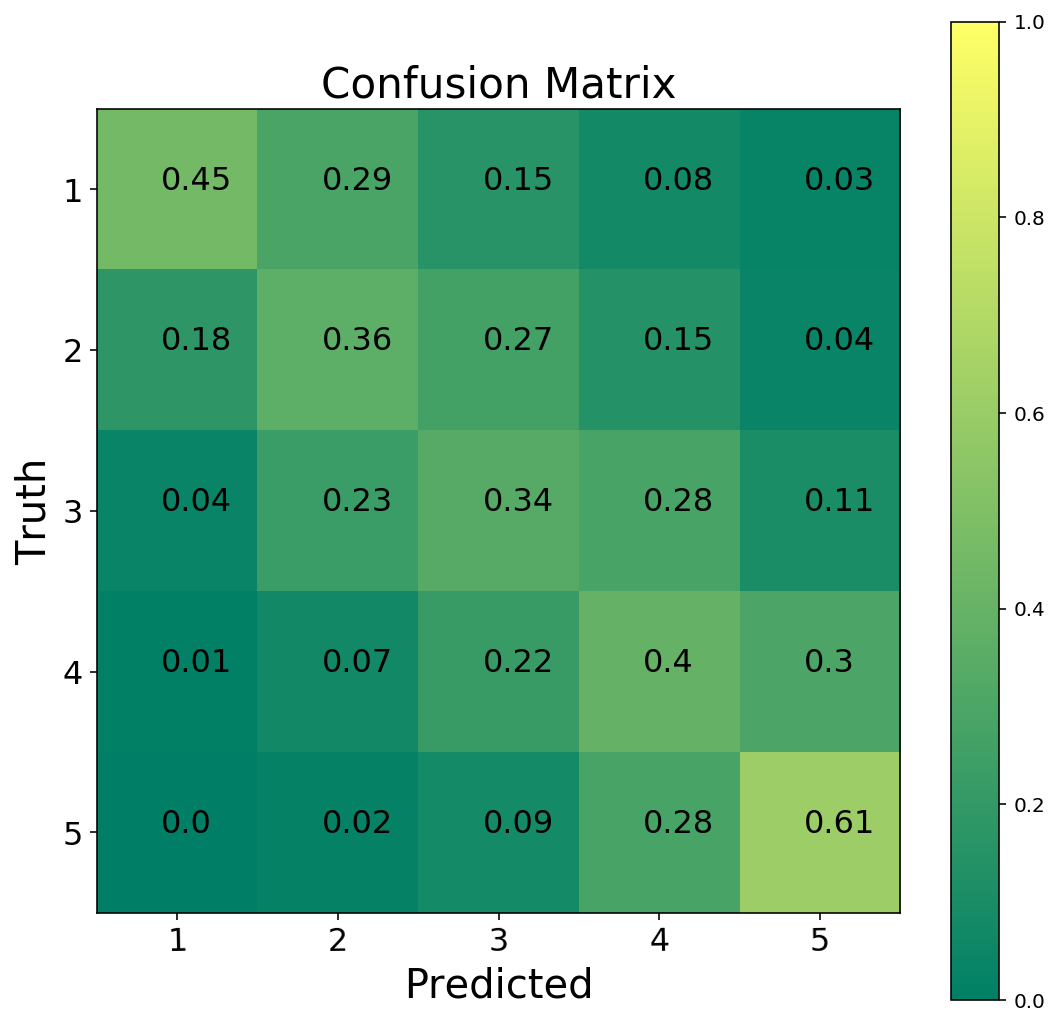

In [727]:
plot_confusion_matrix(item100_train_actual, i100a, labels={0:'1',1:'2',2:'3',3:'4',4:'5'})

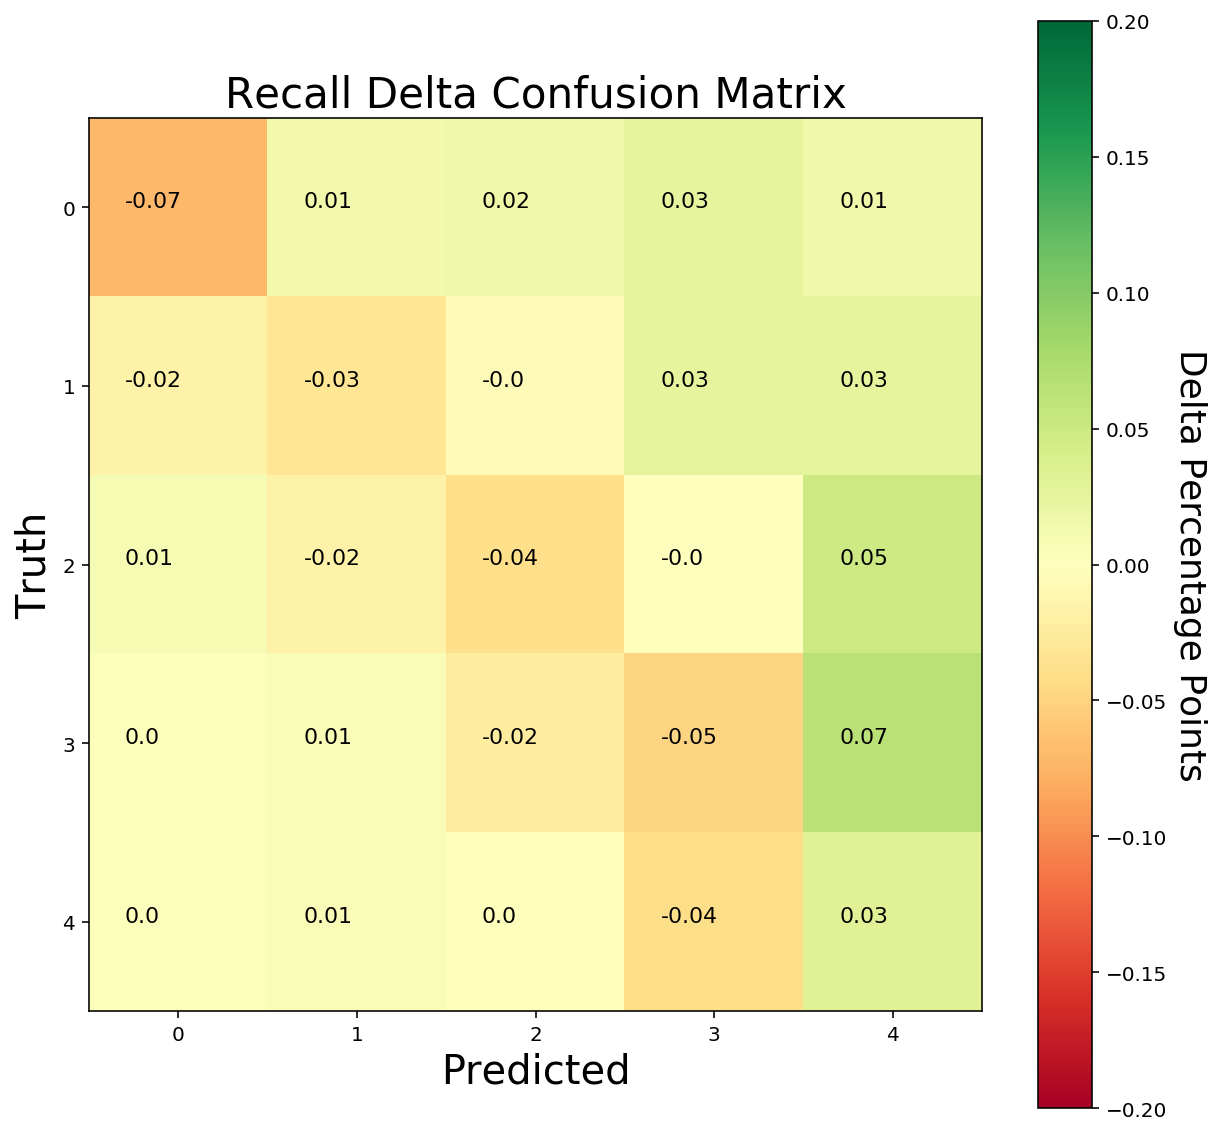

In [745]:
plot_delta_matrix(item100_train_actual, i100a, u100a)

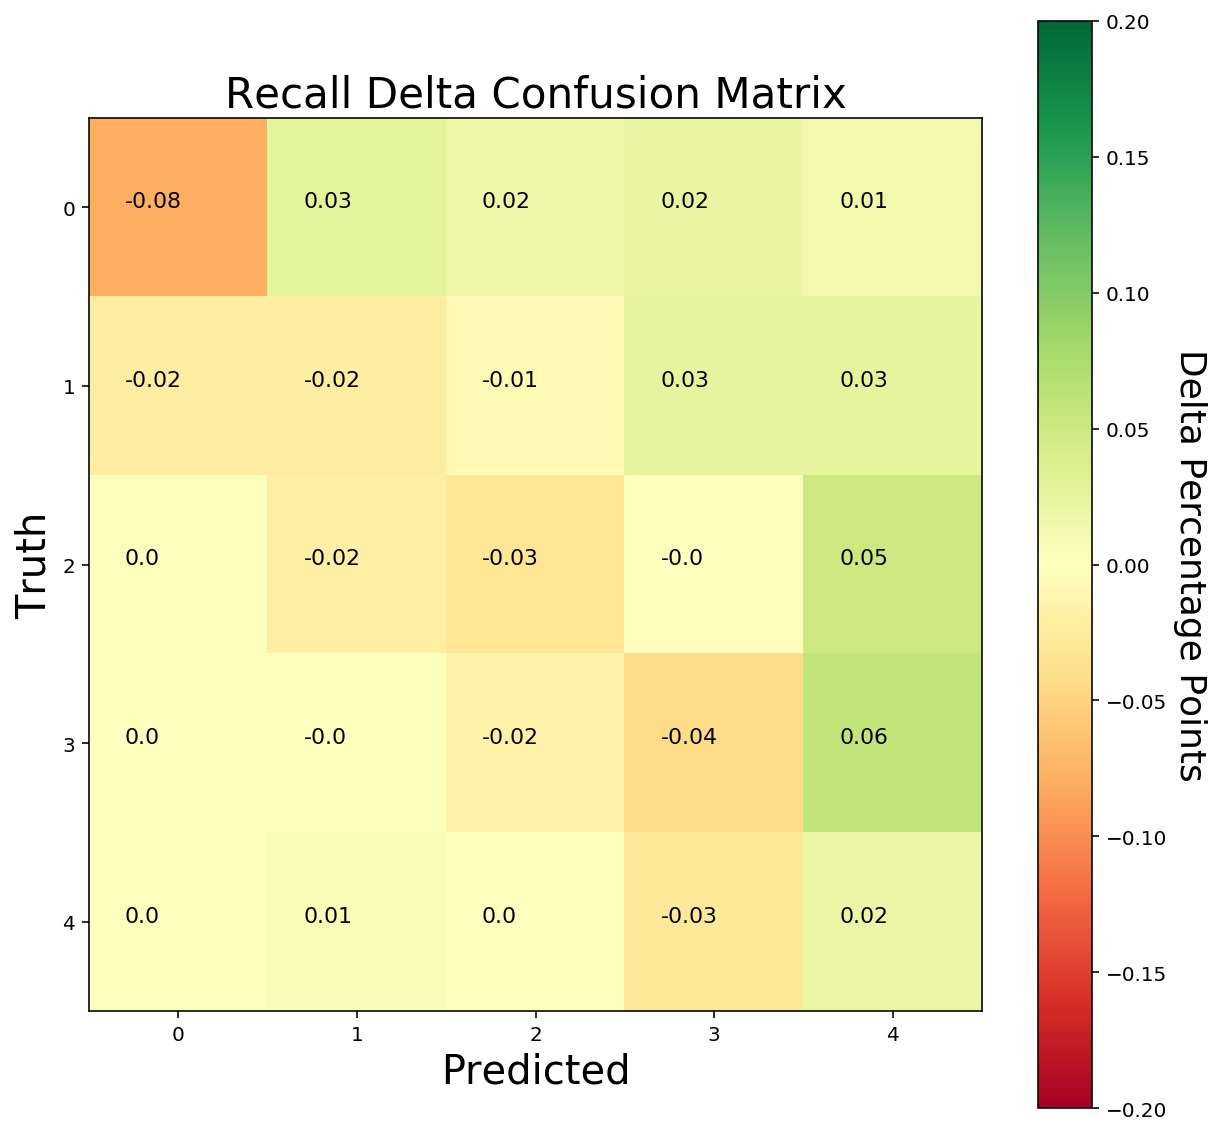

In [744]:
plot_delta_matrix(item100_test_actual, i100b, u100b)

             precision    recall  f1-score   support

          1       0.40      0.45      0.43      5547
          2       0.25      0.35      0.29     10397
          3       0.38      0.33      0.36     25929
          4       0.46      0.39      0.42     34869
          5       0.51      0.59      0.55     23278

avg / total       0.43      0.42      0.42    100020



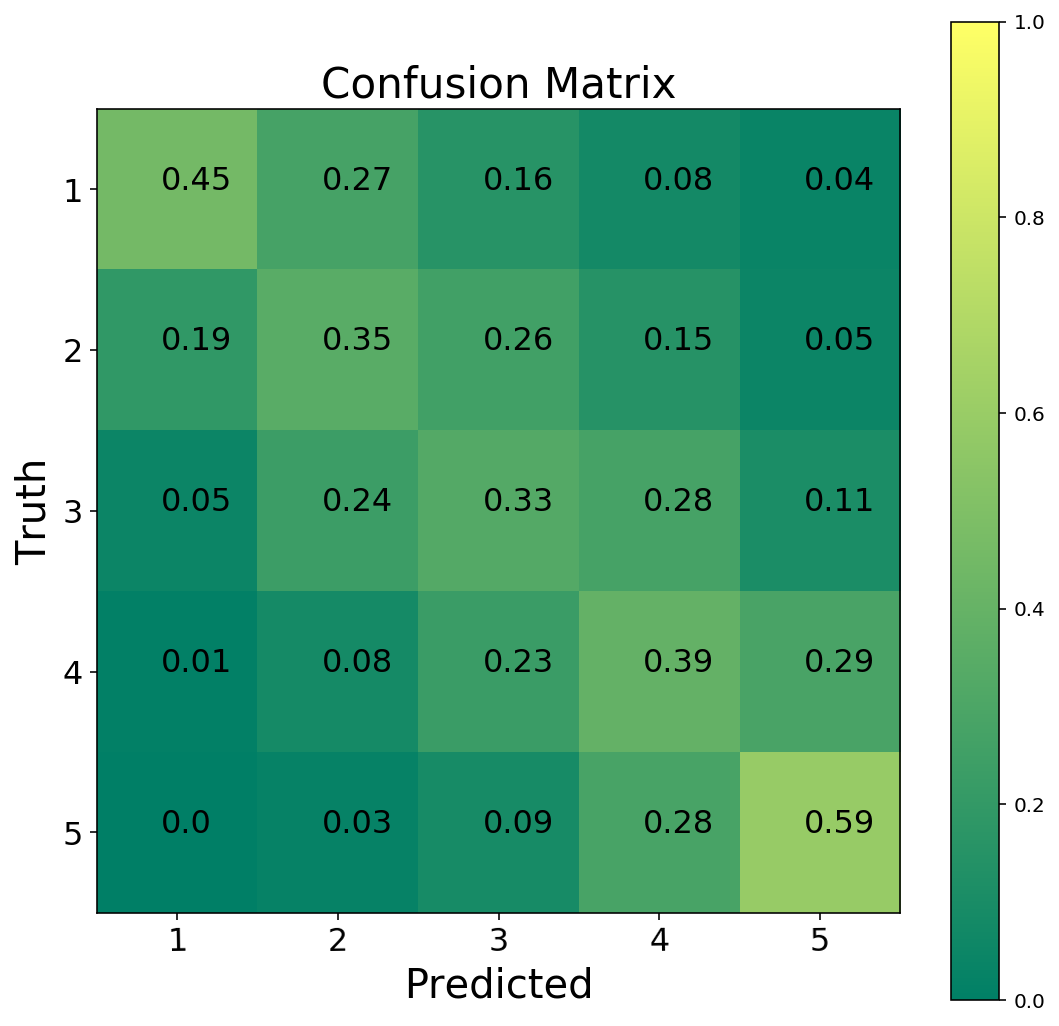

             precision    recall  f1-score   support

          1       0.31      0.48      0.38      5547
          2       0.21      0.31      0.25     10397
          3       0.37      0.27      0.31     25929
          4       0.45      0.33      0.38     34869
          5       0.46      0.62      0.53     23278

avg / total       0.40      0.39      0.38    100020



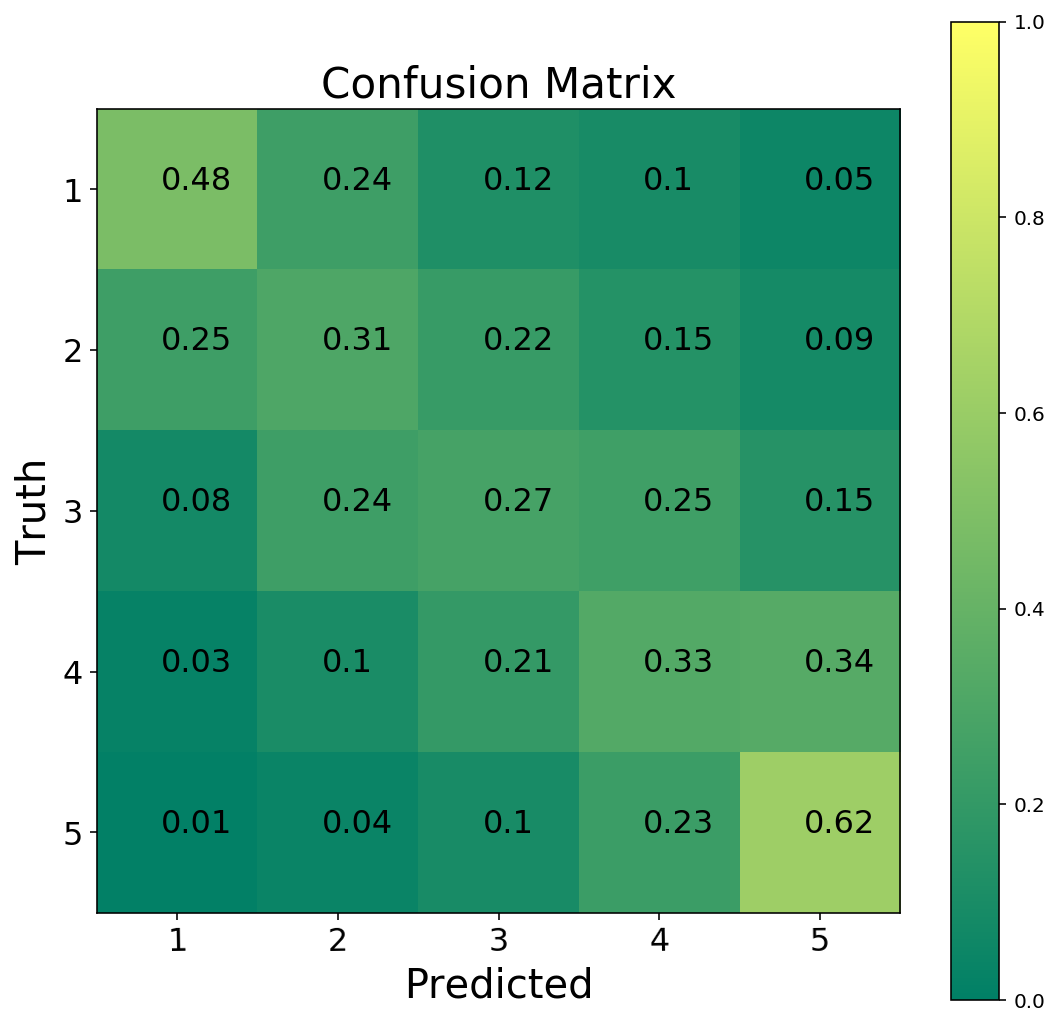

In [767]:
plot_confusion_matrix(item100_test_actual, i100b, labels={0:'1',1:'2',2:'3',3:'4',4:'5'})
plt.show()
plot_confusion_matrix(item100_test_actual, i10b, labels={0:'1',1:'2',2:'3',3:'4',4:'5'})

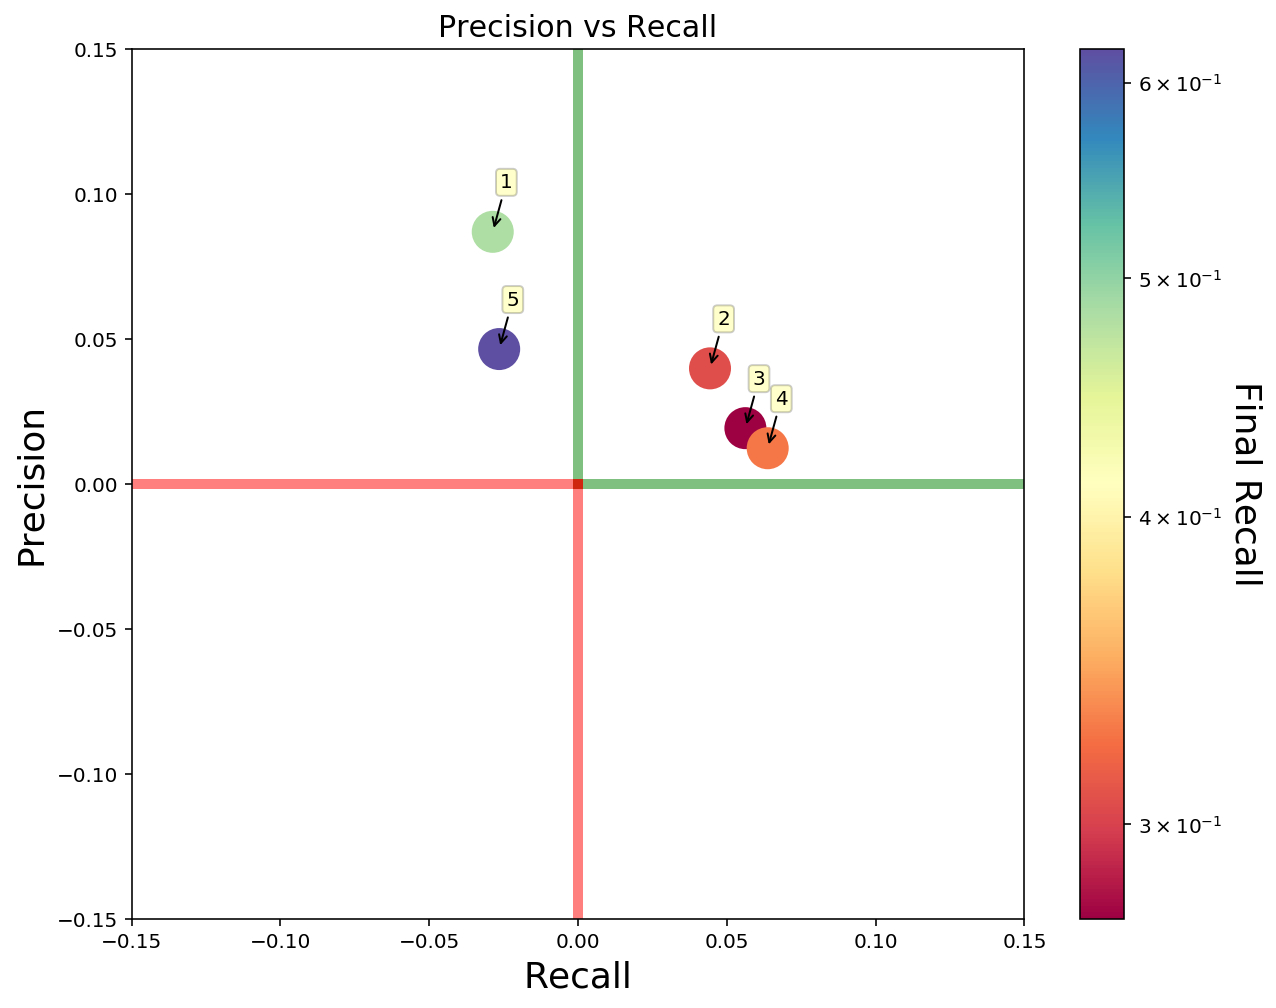

In [784]:
plot_delta_rpc(item100_test_actual, i10b, i100b, labels={0:1,1:2,2:3,3:4,4:5})

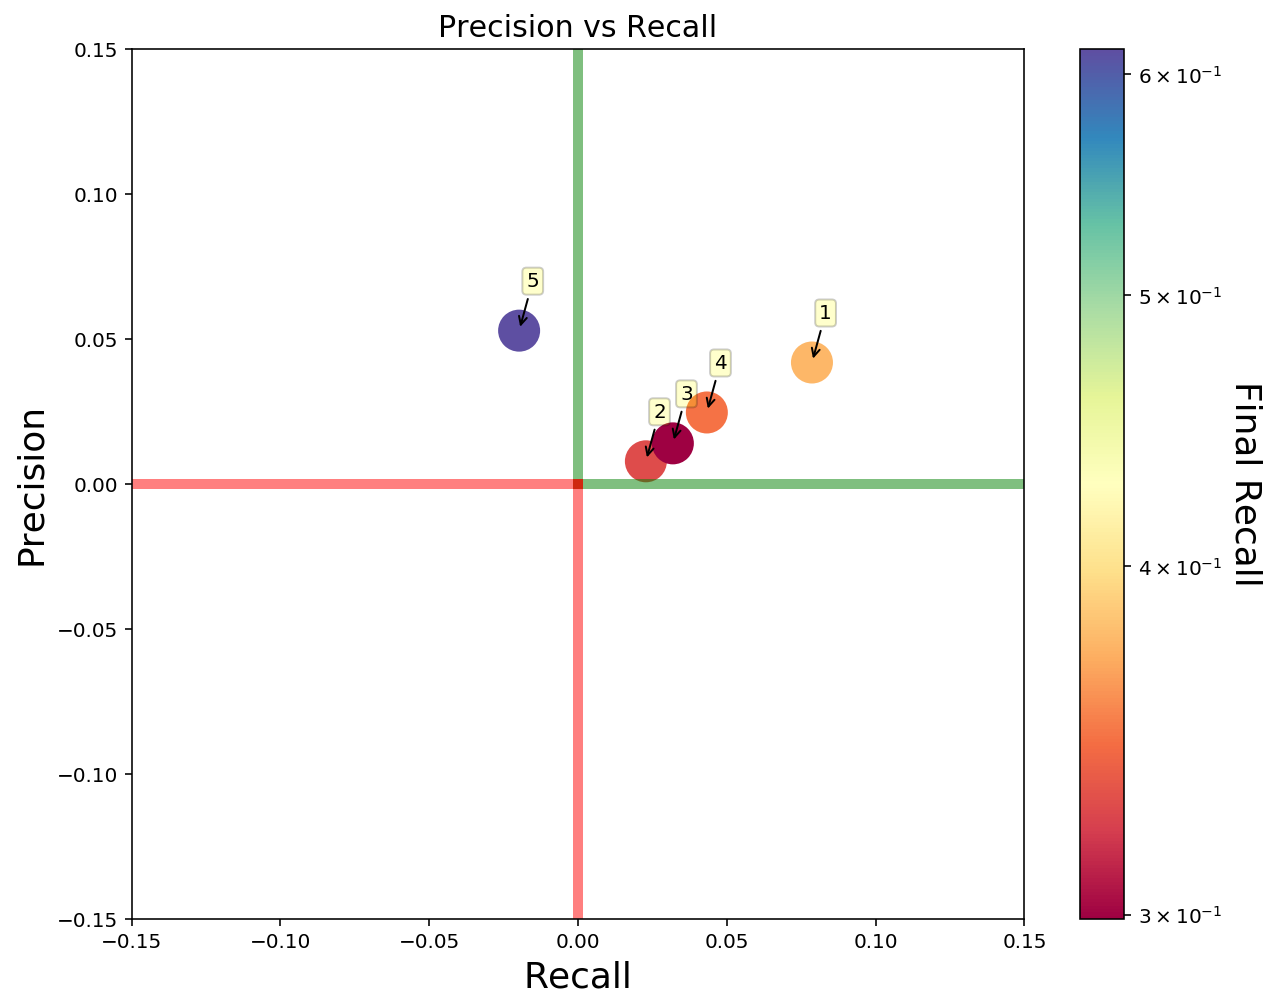

In [785]:
plot_delta_rpc(item100_test_actual, u100b, i100b, labels={0:1,1:2,2:3,3:4,4:5})